# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
from numpy import linalg as la
# from scipy.optimize import curve_fit
from scipy import ndimage

%matplotlib inline

In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD3L1D_STK(xAxis, tAxis, sigma_dict, tPara_ict, spaceDivideStep = 1, timeDivideStep = 60):
# divideStep upsample rate
# tPara_dict must include these temporal parameters: alpha, beta, gamma, g, h, l 
    dx = np.mean(np.diff(xAxis)) / spaceDivideStep
    xAxis = AxisByHalfLen(xAxis[-1], dx)
    gaussK = {} # Gassian Kernel
    for (key,value) in sigma_dict.items():
        halfKLen = min( value*8, xAxis[-1])
        kAxis = AxisByHalfLen(halfKLen, dx)
        gaussK[key] = Gaussian_filter_1d(kAxis,value)

    dt = np.mean(np.diff(tAxis)) / timeDivideStep
    tAxis = np.arange(0, tAxis[-1]+dt, dt)
    stimulus = np.zeros([len(tAxis), len(xAxis)])
    if "tau_delay" in tPara_ict:
        delayed_delta = tAxis /tPara_dict['tau_delay']/tPara_dict['tau_delay'] *np.exp(-tAxis/tPara_dict['tau_delay']) *dt
        stimulus[:,int(len(xAxis)/2)] = delayed_delta
    else:
        stimulus[0,int(len(xAxis)/2)] = 1

    for key in ['alpha','beta','gamma','m','n','g','h','l']: # initialize tPara_ict
        if not key in tPara_ict.keys(): 
            tPara_ict[key] = 1

    z = np.zeros_like(stimulus)
    y = np.zeros_like(stimulus)
    w = np.zeros_like(stimulus)

    for i in np.arange(len(tAxis)-1):
        R = {'s2y':stimulus[i,:], 'y2z':y[i,:], 'y2w':y[i,:], 'z2y':z[i,:], 'z2w':z[i,:]} # initialization
        for key in R.keys():
            if key in gaussK:    R[key] = np.convolve(R[key],gaussK[key],'same')*dx

        dy = (-tPara_dict['alpha']*y[i,:] + tPara_dict['m']*R['s2y'] - tPara_dict['n']*R['z2y'])*dt
        dz = (-tPara_dict['beta'] *z[i,:] + tPara_dict['g']*R['y2z']                           )*dt
        dw = (-tPara_dict['gamma']*w[i,:] + tPara_dict['h']*R['y2w'] - tPara_dict['l']*R['z2w'])*dt

        y[i+1,:] = (y[i,:]+dy)
        z[i+1,:] = (z[i,:]+dz)
        w[i+1,:] = (w[i,:]+dw)
    actual_xAxisIndex = np.append( np.arange(int(len(xAxis)/2), -1, -spaceDivideStep)[:0:-1], np.arange(int(len(xAxis)/2), len(xAxis), spaceDivideStep) )
    y = y[::timeDivideStep, actual_xAxisIndex]/dx/dt #
    z = z[::timeDivideStep, actual_xAxisIndex]/dx/dt
    w = w[::timeDivideStep, actual_xAxisIndex]/dx/dt

    return w, z, y

def AxisByHalfLen(halfLen, dx):
    axis = np.arange(0, halfLen+dx, dx)
    return np.append(-1*axis[:0:-1], axis)


In [3]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Set Parameter

## Exp

In [4]:
# temporal
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':1.302408,
'beta':13.024075,
'gamma':34.901452,
'g':460.016331,
'l':0.021331,
'tau_delay':0.028650,
'm':127.832600} # m can be nagative for off cell

# spatial
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 
sigma_dict['y2z'] = 0.05*sigma_dict['y2w']   # has to be small enough

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) # Half length of xais, (mm)
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

## By hand

In [5]:
# temporal
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':40,
'beta':2,
'gamma':100,
'm':40,
'n':200,
'g':2,
'h':50,
'l':50,
'tau_delay':0.02} # m can be nagative for off cell

# spatial
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
# sigma_dict['y2z'] =10/9*sigma_dict['y2w'] 
sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) # Half length of xais, (mm)
# hXstep =  int(1.015 /dx) # range of Checkboard, 1.5*sqrt(2)/2
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

# STK

In [6]:
Delta_output_w, zts, Delta_output_y = NGD3L1D_STK(SKxaxis, TKtaxis, sigma_dict, tPara_dict)

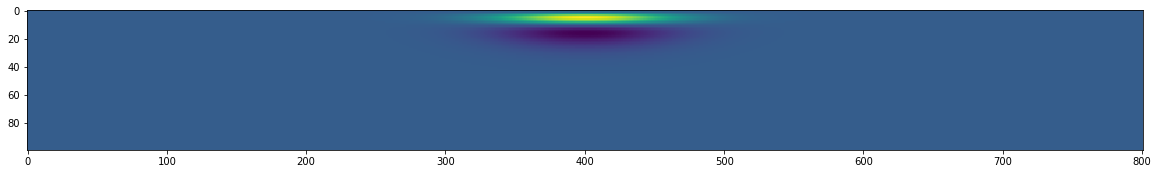

In [7]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)


In [8]:
delSTK = Delta_output_w

In [9]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
mag_Se2del = 1/np.max(SeSTK)*np.max(delSTK)
SeSTK = SeSTK*mag_Se2del

# SVD

In [10]:
U,sigma,VT=la.svd(delSTK)

In [11]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[9.90640489e-01 9.35951084e-03 2.03966090e-16 9.89848651e-17
 9.89848651e-17]


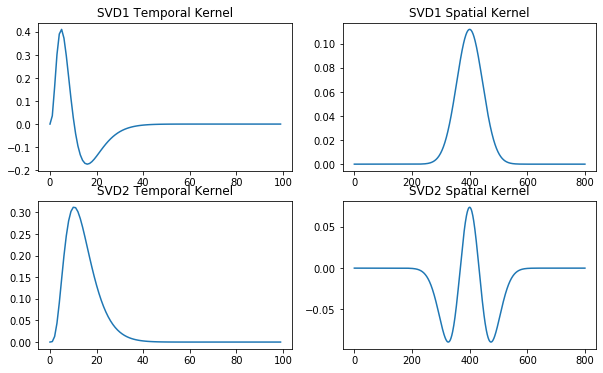

In [12]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(10, 6)

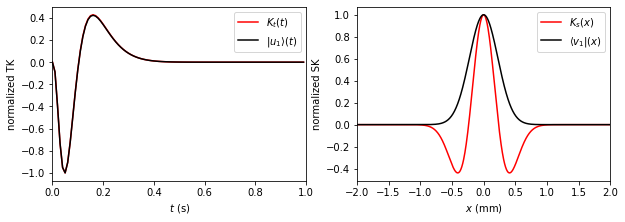

In [13]:
fig, ax = plt.subplots(1,2)
ax[1].plot(SKxaxis, iSK/np.max(iSK), 'r',label=r'$K_s(x)$')
ax[1].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), 'k',label=r'$\left\langle {v_1} \right|(x)$')
# ax[1].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), 'g--',label=r'$K_{st}(\arg\min_{t} K_{st}, x)$')
ax[1].legend(loc='best')
ax[1].set_ylabel('normalized SK')
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_xlim([-2,2])

ax[0].plot(TKtaxis, -iTK/np.max(iTK), 'r',label=r'$K_t(t)$')
ax[0].plot(TKtaxis, -U[:,0]/np.max(U[:,0]), 'k', label=r'$\left| u_1 \right\rangle(t)$')
# ax[0].plot(TKtaxis, -delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), 'g--',label=r'$K_{st}(t, \arg\min_{x} K_{st})$')
ax[0].set_xlabel(r'$t$ (s)')
ax[0].set_ylabel('normalized TK')
ax[0].set_xlim([0,1])
# ax[0].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best')
fig.set_size_inches(10,3.2)

(0, 20)

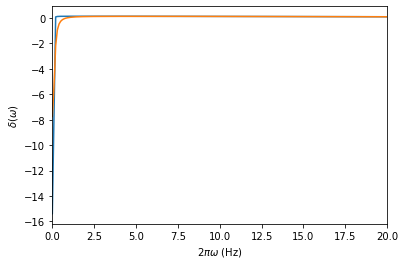

In [14]:
df = 0.1
faxis = np.arange(-50,50,df)

F_TK = np.sum(iTK[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
F_TK = np.sum(U[:,0][np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'2$\pi\omega$ (Hz)')
plt.xlim([0,20])

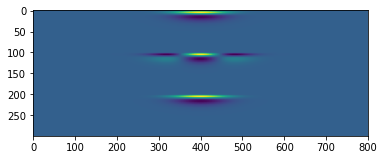

In [15]:
plt.imshow(np.vstack((delSTK,SeSTK,SVDSTK)))

# WF(LPOU)+GC

In [16]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from StimulusnResponse import SSG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [17]:
DR = 1.4 #mm
dDR = int(DR/dx+0.5)

Tto = 300
LPOUtaxis = np.arange(0,Tto,dt)
LPOU_list = SSG([0.5,1,2,4], dt, Tto, tau = 1, D = 1)
# sti_list = [ (LPOU-np.mean(LPOU))/np.std(LPOU)*2 + 10  for LPOU in LPOU_list]
sti_list = LPOU_list

In [18]:
r_list    = [ np.convolve(sti, iTK/max(iTK),       'full')[:len(sti)]  for sti in sti_list]
SVDr_list = [ np.convolve(sti, U[:,0]/max(U[:,0]), 'full')[:len(sti)]  for sti in sti_list]

## Without Gain

### STA

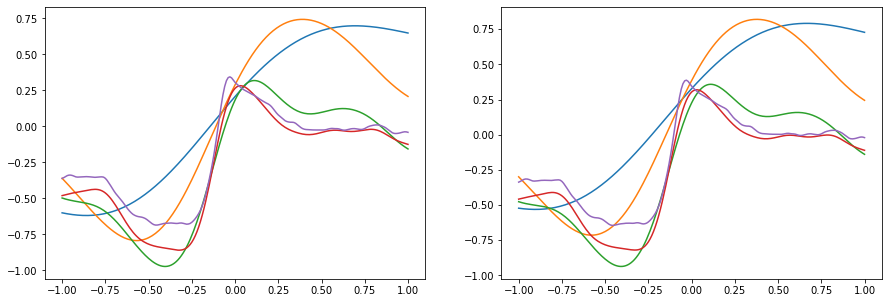

In [30]:
fig, ax = plt.subplots(1,2)
Xcorr_list = []
SVD_Xcorr_list = []
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
theta = 2
for i in range(len(LPOU_list)):
    NLr = NL(r_list[i], np.mean(r_list[i])+theta*np.std(r_list[i]))
    Xcorr = np.correlate(LPOU_list[i], NLr, 'same')/np.correlate(np.ones_like(LPOU_list[i]), NLr, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    Xcorr_list.append( Xcorr.copy() )

    NL_SVDr = NL(SVDr_list[i], np.mean(SVDr_list[i])+theta*np.std(r_list[i]))
    Xcorr = np.correlate(LPOU_list[i], NL_SVDr, 'same')/np.correlate(np.ones_like(LPOU_list[i]), NL_SVDr, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    SVD_Xcorr_list.append( Xcorr.copy() )
for i in range(len(LPOU_list)):
    ax[0].plot(timeaxis, Xcorr_list[i])
    ax[1].plot(timeaxis, SVD_Xcorr_list[i])
fig.set_size_inches(15,5)

### MI

In [27]:
tv_list = [ndimage.gaussian_filter1d(sti, order=1, sigma=1)/dt  for sti in sti_list]
#assign states
state_num = 6
xstate_list = [EqualState(sti, state_num)[0] for sti in sti_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

rstate_list    = [SG(r, dt, 0, 2, 10) for r in r_list]
SVDrstate_list = [SG(r, dt, 0, 2, 10) for r in SVDr_list]

In [28]:
Information_list = [0]*len(LPOU_list)
SVDInformation_list = [0]*len(LPOU_list)
for i in range(len(LPOU_list)):
    timeshift, Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], tvstate_list[i], dt, window)
    timeshift, SVDInformation_list[i] = PIfunc(SVDrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

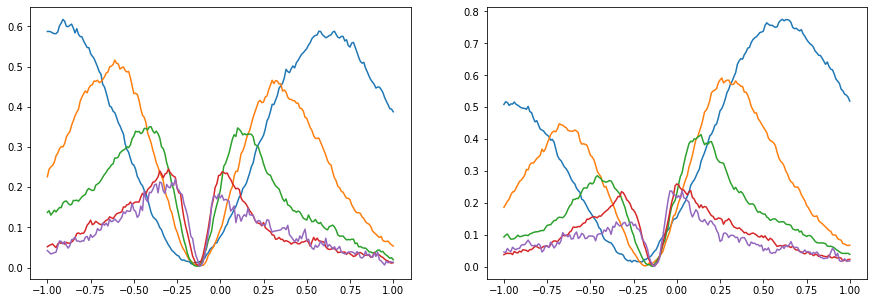

In [29]:
fig, ax = plt.subplots(1,2)
for i in range(len(LPOU_list)):
    ax[0].plot(timeaxis, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    ax[1].plot(timeaxis, SVDInformation_list[i][('Beer','UIx')]+SVDInformation_list[i][('Beer','Red')])
fig.set_size_inches(15,5)